# introduction to the vectorizing principle

## part 4: defining a data pipeline

Here, we are focusing on data transformation code used for curating data or training and evaluating a model. In this case, a data pipeline can be used as a means of splitting the work in pieces that are conceptionally relevant for creating, operating, or maintaining the code. One can see a data pipeline as a directed acyclic graph (DAG) of tasks. Often a hierarchical notion of grouping the tasks is useful for example grouping them in stages. Typical stages of a data pipeline may be:

1. raw data ingestion
2. early cleaning for easier inspection
3. transformation in the best possible form for subject matter reasoning
4. feature enrichment
5. model training
6. model evaluation

Data pipeline orchestration tools can help with tracing/monitoring different executions of the pipeline. They may help with communication between tasks as well as materializations/dematerializations to persistent storage (files or databases). They may introduce transactionality features like showing the result of a stage only on success. And they can help with caching and automatic cache-invalidation. It helps to think of intermediate data within a pipeline as caches since they (should) only depend on external inputs into the pipeline and the code running it. Often a notion of caching is implemented in an ad-hoc fasion with manual control but this causes trouble if multiple instances of the pipeline should be operated in order to ensure an agile development process working with small, medium, large input data both with per-user and team shared caches. For most data analytic pipelines, the algorithm is not fixed upfront. It is developed as part of the creation process. Thus, a high development iteration speed is key! Good software design and reproduction/testing strategies are needed to keep up the speed long enough to create maximum value.

#### define tasks:

In [21]:
import pandas as pd
import numpy as np
from pydiverse.pipedag.materialize import Blob, Table, materialize
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math

@materialize(version="1.0.0")
def read_input_data():
    data_df = pd.read_csv('data/taxi_data/train.csv.gz')
    return Table(data_df, name="input_data")


@materialize(version="1.0.0", input_type=pd.DataFrame)
def feature_trip_distance(df: pd.DataFrame):
    start_lat = np.radians(df["pickup_latitude"])
    start_lng = np.radians(df["pickup_longitude"])
    dest_lat = np.radians(df["dropoff_latitude"])
    dest_lng = np.radians(df["dropoff_longitude"])

    d = (
        np.sin(dest_lat / 2 - start_lat / 2) ** 2
        + np.cos(start_lat)
        * np.cos(dest_lat)
        * np.sin(dest_lng / 2 - start_lng / 2) ** 2
    )

    return Table(pd.DataFrame(
        dict(
            id=df["id"],
            # 6,371 km is the earth radius
            haversine_distance = 2 * 6371 * np.arcsin(np.sqrt(d))
        )
    ), name="trip_distance")

@materialize(version="1.0.0", input_type=pd.DataFrame)
def feature_split_pickup_datetime(df: pd.DataFrame):
    tpep_pickup_datetime = pd.to_datetime(df["pickup_datetime"])

    return Table(pd.DataFrame(
        dict(
            id=df["id"],
            pickup_dayofweek=tpep_pickup_datetime.dt.dayofweek,
            pickup_hour=tpep_pickup_datetime.dt.hour,
            pickup_minute=tpep_pickup_datetime.dt.minute,
        )
    ), name="pickup_datetime")

@materialize(nout=2, version="1.0.0", input_type=pd.DataFrame)
def get_feature_df(df: pd.DataFrame, features: list[pd.DataFrame], target_col="trip_duration"):
    final_df = df[["id"] + [col for col in df.columns if col != target_col and df[col].dtype in (int, float, bool)]]
    for feature_df in features:
        final_df = final_df.merge(feature_df, on="id")
    return (
        Table(final_df, name="features"),
        Table(df[["id", target_col]], name="target"),
    )


def combine_features(data_df):
    features = [
        feature_trip_distance(data_df),
        feature_split_pickup_datetime(data_df),
    ]
    return get_feature_df(data_df, features)


@materialize(nout=4, version="1.0.0", input_type=pd.DataFrame)
def split_train_test(features_df: pd.DataFrame, target_df: pd.DataFrame):
    features_df.sort_values("id", inplace=True)
    target_df.sort_values("id", inplace=True)
    (
        features_train,
        features_test,
        target_train,
        target_test,
    ) = train_test_split(features_df, target_df, test_size=0.1)
    return (
        Table(features_train, name="features_train"),
        Table(features_test, name="features_test"),
        Table(target_train, name="target_train"),
        Table(target_test, name="target_test"),
    )

@materialize(version="1.0.0", input_type=pd.DataFrame)
def train_model(features_train: pd.DataFrame, target_train: pd.DataFrame):
    features_train.sort_values("id", inplace=True)
    target_train.sort_values("id", inplace=True)
    del features_train["id"]
    del target_train["id"]
    model = lightgbm.LGBMRegressor(objective="regression_l1")
    model.fit(features_train, target_train)
    return Blob(model, name="model")


@materialize(version="1.0.0", input_type=pd.DataFrame)
def evaluate_model(features_test: pd.DataFrame, target_test: pd.DataFrame, model: lightgbm.LGBMRegressor):
    features_test.sort_values("id", inplace=True)
    target_test.sort_values("id", inplace=True)
    del features_test["id"]
    del target_test["id"]
    predicted = model.predict(features_test)
    print(model.score(features_test, target_test))
    print(math.sqrt(mean_squared_error(target_test, predicted)))
    lightgbm.plot_importance(model)

#### define pipeline:

In [22]:
from pydiverse.pipedag.core import Flow, PipedagConfig, Stage
def get_pipeline():
    with Flow("vectorization") as flow:
        with Stage("01_raw_input"):
            data_df = read_input_data()
        with Stage("02_features"):
            features_df, target_df = combine_features(data_df)
            (
                features_train,
                features_test,
                target_train,
                target_test,
            ) = split_train_test(features_df, target_df)
        with Stage("03_model"):
            model = train_model(features_train, target_train)
        with Stage("04_evaluation"):
            evaluate_model(features_test, target_test, model)
    return flow

#### setup logging:

In [23]:
import logging
from pydiverse.pipedag.util.structlog import setup_logging
setup_logging(log_level=logging.INFO)


#### run pipeline:

2023-08-06 11:16:12.084629 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-06 11:16:12.090340 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:34323
2023-08-06 11:16:12.095326 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2023-08-06 11:16:12.105609 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2023-08-06 11:16:12.116993 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS "01_raw_input"
2023-08-06 11:16:12.118651 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP SCHEMA IF EXISTS "01_raw_input__even" CASCADE
2023-08-06 11:16:12.119873 [info     ] Executing sql                  

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 1312779, number of used features: 4
[LightGBM] [Info] Start training from score 662.000000


2023-08-06 11:16:28.841394 [info     ] Task finished successfully     [Task 'train_model'] state=<FinalTaskState.COMPLETED: 1> task=<Task 'train_model' 0x7fe7ad2c53f0 (id: 7)>
2023-08-06 11:16:28.844062 [info     ] Committing stage               [Commit Stage] stage=<Stage: 03_model>
2023-08-06 11:16:28.854112 [info     ] Stage is cache valid           [DuckDBTableStore] stage=<Stage: 03_model>
2023-08-06 11:16:28.867616 [info     ] Task finished successfully     [Commit Stage] stage=<Stage: 03_model> state=<FinalTaskState.COMPLETED: 1>
2023-08-06 11:16:28.878384 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA IF NOT EXISTS "04_evaluation"
2023-08-06 11:16:28.882299 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    DROP SCHEMA IF EXISTS "04_evaluation__odd" CASCADE
2023-08-06 11:16:28.884257 [info     ] Executing sql                  [DuckDBTableStore] 
    [query]
    CREATE SCHEMA "04_evaluation__odd"
2023-08-0

0.027864378576514914
3203.8721213701747


2023-08-06 11:16:31.359303 [info     ] Task finished successfully     [Task 'evaluate_model'] state=<FinalTaskState.COMPLETED: 1> task=<Task 'evaluate_model' 0x7fe7ad2c6d70 (id: 9)>
2023-08-06 11:16:31.361430 [info     ] Committing stage               [Commit Stage] stage=<Stage: 04_evaluation>
2023-08-06 11:16:31.366461 [info     ] Stage is cache valid           [DuckDBTableStore] stage=<Stage: 04_evaluation>
2023-08-06 11:16:31.375305 [info     ] Task finished successfully     [Commit Stage] stage=<Stage: 04_evaluation> state=<FinalTaskState.COMPLETED: 1>
2023-08-06 11:16:31.579497 [info     ] Stopped IPCServer              [RunContextServer] address=tcp://127.0.0.1:34323
2023-08-06 11:16:31.615112 [info     ] Flow visualization             [Flow] url=https://kroki.io/graphviz/svg/eNqlktFqgzAUhu_zFMHddmDVrhNxt3uIMcLRnLjQVCU5bozRd582dmtFRKg3PyZ8fz5yInVlof3gr_yHua7wP6XpHKEV4VZY-BK6bjvq94uqbExj8-AhPH9RGGTMLxUGykPGVFPTzYKBAk0eXBf1jKNvg7lrjJYZC_mb0sZcqvFZqfIp2HCPWgTpOSGBYMM9GwwIyuA9Yyc2Ix

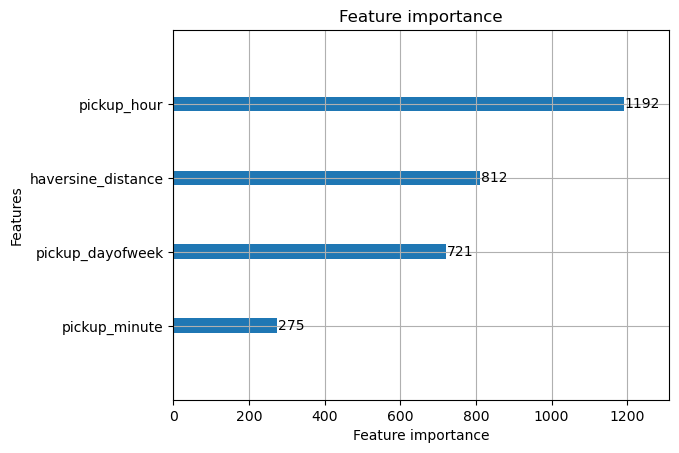

In [24]:
flow = get_pipeline()
result = flow.run()
assert result.successful

Next: [vectorization05a.ipynb](vectorization05a.ipynb): generating SQL and dataframe transformation code with one syntax